In [6]:
import requests
import random
import json
import time
from collections import defaultdict
from requests.auth import HTTPBasicAuth

username = "read-3687935da6ba7c8f1fe64bb57b2ba3b9"
password = "MkSU5/rFvhzGuuO36Vgo2DkP5L4AIVXmommL3gkh"

url = "https://api.ravelry.com/patterns/search.json"
headers = {"User-Agent": "DesignerLimitBot/1.0"}

# 디자이너별 도안 개수를 저장할 dict
designer_counts = defaultdict(int)
all_patterns = []
success_count = 0
page = 1
max_patterns_per_designer = 20

while success_count < 15 and page <= 2000:
    params = {"page": page, "page_size": 100}
    resp = requests.get(url, auth=HTTPBasicAuth(username, password), params=params, headers=headers)

    if resp.status_code != 200:
        print(f"❌ Page {page} failed: {resp.status_code}")
        page += 1
        time.sleep(1)
        continue

    patterns = resp.json().get("patterns", [])
    added_count = 0

    for p in patterns:
        designer = p.get("designer", {}).get("name")
        if not designer:
            continue
        if designer_counts[designer] >= max_patterns_per_designer:
            continue
        all_patterns.append(p)
        designer_counts[designer] += 1
        added_count += 1

    if added_count > 0:
        print(f"✅ Page {page}: {added_count}개 도안 추가 (누적: {len(all_patterns)})")
        success_count += 1
    else:
        print(f"⚠️ Page {page}: 조건에 맞는 도안 없음")

    page += random.randint(1, 10)
    time.sleep(1)

# 저장
with open("patterns_sample.json", "w", encoding="utf-8") as f:
    json.dump({"patterns": all_patterns}, f, ensure_ascii=False, indent=2)

print(f"🎉 총 저장된 도안 수: {len(all_patterns)}")
print(f"📌 포함된 디자이너 수: {len(designer_counts)}")


✅ Page 1: 100개 도안 추가 (누적: 100)
✅ Page 5: 97개 도안 추가 (누적: 197)
✅ Page 6: 90개 도안 추가 (누적: 287)
✅ Page 8: 92개 도안 추가 (누적: 379)
✅ Page 9: 93개 도안 추가 (누적: 472)
✅ Page 19: 94개 도안 추가 (누적: 566)
✅ Page 22: 98개 도안 추가 (누적: 664)
✅ Page 24: 92개 도안 추가 (누적: 756)
✅ Page 29: 96개 도안 추가 (누적: 852)
✅ Page 38: 97개 도안 추가 (누적: 949)
✅ Page 46: 98개 도안 추가 (누적: 1047)
✅ Page 50: 94개 도안 추가 (누적: 1141)
✅ Page 54: 96개 도안 추가 (누적: 1237)
✅ Page 64: 98개 도안 추가 (누적: 1335)
✅ Page 66: 99개 도안 추가 (누적: 1434)
🎉 총 저장된 도안 수: 1434
📌 포함된 디자이너 수: 706


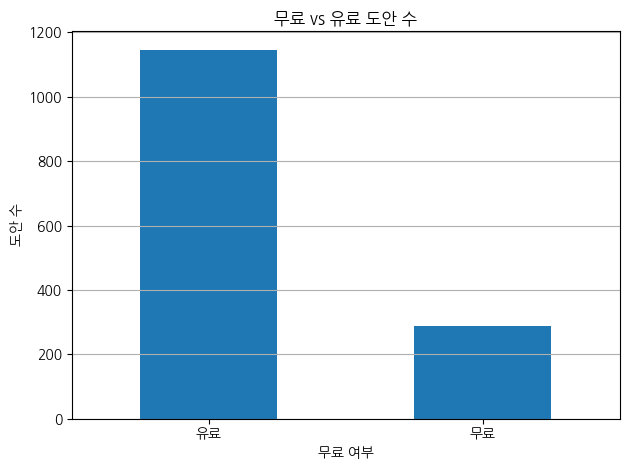

C:\Users\paint\AppData\Local\Temp\ipykernel_18428\786023941.py:49: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from font(s) NanumGothic.
  plt.tight_layout()
c:\Users\paint\anaconda3\envs\stat\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 252 (\N{LATIN SMALL LETTER U WITH DIAERESIS}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


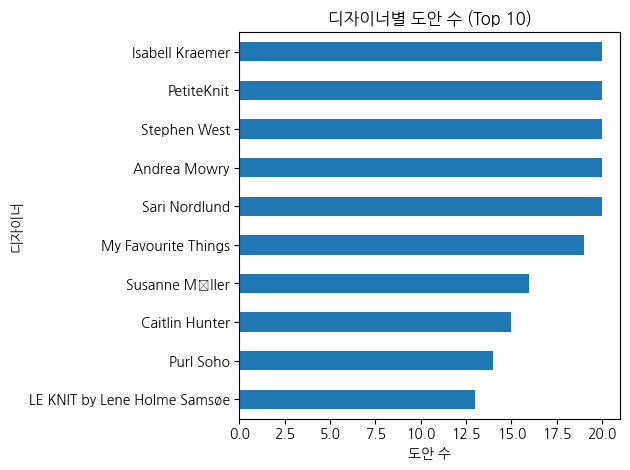

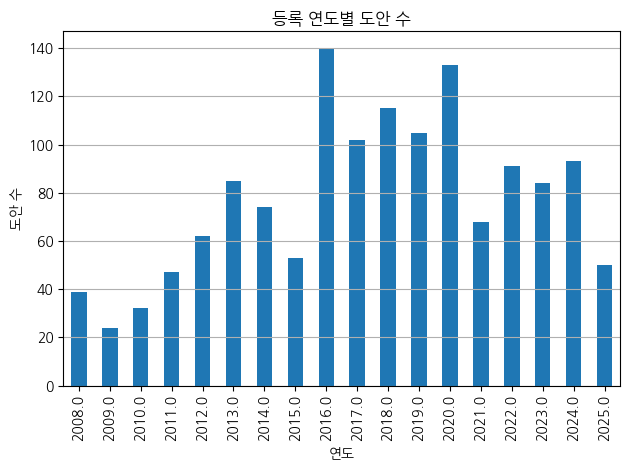

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
# JSON 파일 불러오기
with open("patterns_sample.json", "r", encoding="utf-8") as f:
    data = json.load(f)

patterns = data["patterns"]
df = pd.json_normalize(patterns)

# created_at 안정적으로 추출 → 문자열 → datetime 변환
def extract_created_at(x):
    if isinstance(x, list) and len(x) > 0 and "created_at" in x[0]:
        return x[0]["created_at"]
    return None

df["created_at_raw"] = df["pattern_sources"].apply(extract_created_at)
df["created_at"] = pd.to_datetime(df["created_at_raw"], errors="coerce", utc=True)

# 분석용 데이터프레임 구성
df_analysis = pd.DataFrame({
    "pattern_id": df["id"],
    "name": df["name"],
    "is_free": df["free"],
    "designer": df["designer.name"],
    "created_at": df["created_at"]
})

# 연도 추출 (datetime 변환 실패한 행은 제외됨)
df_analysis["year"] = df_analysis["created_at"].dt.year

# =====================
# 1. 무료/유료 도안 수
# =====================
free_counts = df_analysis["is_free"].value_counts()
free_counts.plot(kind="bar", title="무료 vs 유료 도안 수", xlabel="무료 여부", ylabel="도안 수")
plt.xticks(ticks=[0,1], labels=["유료", "무료"], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# =============================
# 2. 디자이너별 도안 수 (Top 10)
# =============================
top_designers = df_analysis["designer"].value_counts().head(10)
top_designers.plot(kind="barh", title="디자이너별 도안 수 (Top 10)", xlabel="도안 수", ylabel="디자이너")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================
# 3. 연도별 등록 도안 수
# ============================
year_counts = df_analysis["year"].value_counts().sort_index()
year_counts.plot(kind="bar", title="등록 연도별 도안 수", xlabel="연도", ylabel="도안 수")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [9]:
import json
import requests
import time
import random  # 추가

# ▶ 1. 도안 ID가 들어있는 JSON 파일 경로
with open("patterns_sample.json", "r", encoding="utf-8") as f:
    data = json.load(f)
    pattern_ids = [p.get("id") for p in data.get("patterns", []) if p.get("id")]

random.shuffle(pattern_ids)  # 💡 무작위로 섞기

# ▶ 2. Basic Auth 정보
username = "read-3687935da6ba7c8f1fe64bb57b2ba3b9"
password = "MkSU5/rFvhzGuuO36Vgo2DkP5L4AIVXmommL3gkh"

# ▶ 3. 상세 도안 수집
detailed_patterns = []

for i, pid in enumerate(pattern_ids[:200]):  # 💡 무작위로 뽑은 ID 중 최대 200개
    url = f"https://api.ravelry.com/patterns/{pid}.json"
    resp = requests.get(url, auth=(username, password))
    
    if resp.status_code == 200:
        raw = resp.json().get("pattern", {})
        reduced = {
            "id": raw.get("id"),
            "name": raw.get("name"),
            "craft": raw.get("craft"),
            "languages": raw.get("languages", []),
            "pattern_type": raw.get("pattern_type", {}).get("name"),
            "pattern_attributes": [a["permalink"] for a in raw.get("pattern_attributes", []) if isinstance(a, dict) and "permalink" in a],
            "difficulty_average": raw.get("difficulty_average"),
            "favorites_count": raw.get("favorites_count"),
            "projects_count": raw.get("projects_count"),
            "queued_projects_count": raw.get("queued_projects_count"),
            "rating_average": raw.get("rating_average")            
        }

        print(f"✅ {i+1}/{len(pattern_ids)}: ID {pid} 수집 성공")
        detailed_patterns.append(reduced)
    else:
        print(f"❌ {i+1}/{len(pattern_ids)}: ID {pid} 실패 (code: {resp.status_code})")

    time.sleep(1)

# ▶ 4. 파일로 저장
with open("detailed_patterns.json", "w", encoding="utf-8") as f:
    json.dump(detailed_patterns, f, indent=2, ensure_ascii=False)

print("✅ 저장 완료: detailed_patterns.json")


✅ 1/1434: ID 7382998 수집 성공
✅ 2/1434: ID 1343278 수집 성공
✅ 3/1434: ID 7427979 수집 성공
✅ 4/1434: ID 7405303 수집 성공
✅ 5/1434: ID 7442251 수집 성공
✅ 6/1434: ID 7345318 수집 성공
✅ 7/1434: ID 1297423 수집 성공
✅ 8/1434: ID 7376371 수집 성공
✅ 9/1434: ID 1245297 수집 성공
✅ 10/1434: ID 7332358 수집 성공
✅ 11/1434: ID 7378064 수집 성공
✅ 12/1434: ID 7367459 수집 성공
✅ 13/1434: ID 7390220 수집 성공
✅ 14/1434: ID 7390952 수집 성공
✅ 15/1434: ID 7339819 수집 성공
✅ 16/1434: ID 7438629 수집 성공
✅ 17/1434: ID 7417063 수집 성공
✅ 18/1434: ID 7282096 수집 성공
✅ 19/1434: ID 1307310 수집 성공
✅ 20/1434: ID 7369257 수집 성공
✅ 21/1434: ID 7440026 수집 성공
✅ 22/1434: ID 7326641 수집 성공
✅ 23/1434: ID 7429684 수집 성공
✅ 24/1434: ID 7436683 수집 성공
✅ 25/1434: ID 7400464 수집 성공
✅ 26/1434: ID 7410703 수집 성공
✅ 27/1434: ID 7310737 수집 성공
✅ 28/1434: ID 848341 수집 성공
✅ 29/1434: ID 7395141 수집 성공
✅ 30/1434: ID 7442339 수집 성공
✅ 31/1434: ID 7423234 수집 성공
✅ 32/1434: ID 7442514 수집 성공
✅ 33/1434: ID 7409375 수집 성공
✅ 34/1434: ID 7428975 수집 성공
✅ 35/1434: ID 1218540 수집 성공
✅ 36/1434: ID 7351805 수집 성공
✅ 

In [11]:
import json

# 분류 기준
attribute_categories = {
    "construction": [
        "bias", "bottom-up", "top-down", "seamed", "seamless", "sideways", "in-the-round",
        "worked-flat", "modular", "one-piece", "provisional-cast-on", "three-needle-bind-off",
        "steeks", "gusset", "kitchener", "icord", "moebius", "twined-knitting"
    ],
    "sleeve": [
        "sleeveless", "cap-sleeve", "short-sleeve", "three-quarter-sleeve", "long-sleeve",
        "drop-sleeve", "set-in-sleeve", "dolman-sleeve", "raglan-sleeve"
    ],
    "neckline": [
        "crew-neck", "v-neck", "scoop-neck", "square-neck", "turtleneck", "boatneck"
    ],
    "style": [
        "fitted", "positive-ease", "oversized", "cropped", "textured", "motifs",
        "chart", "written-pattern"
    ],
    "technique": [
        "lace", "cables", "colorwork", "entrelac", "double-knitting", "freeform",
        "felted", "thrums", "selvedge", "short-rows", "buttonholes",
        "video-tutorial", "schematic", "stripes", "stripes-colorwork"
    ]
}

# 데이터 불러오기
with open("detailed_patterns.json", "r", encoding="utf-8") as f:
    patterns = json.load(f)

# 패턴 속성 분류
for p in patterns:
    attr_names = p.get("pattern_attributes", [])  # 문자열 리스트로 바로 사용
    p["pattern_attributes_flat"] = attr_names

    categorized = {}
    for category, keywords in attribute_categories.items():
        categorized[category] = [attr for attr in attr_names if attr in keywords]

    p["attribute_categories"] = categorized

fields_to_keep = [
    "id", "name", "pattern_type", "difficulty_average", "languages",
    "attribute_categories", "craft",
    "favorites_count", "projects_count", "queued_projects_count", "rating_average"
]


# 필터링
filtered_patterns = []
for p in patterns:
    filtered = {k: p.get(k) for k in fields_to_keep}
    filtered_patterns.append(filtered)

# 저장
with open("detailed_patterns_filtered.json", "w", encoding="utf-8") as f:
    json.dump(filtered_patterns, f, indent=2, ensure_ascii=False)

print("✅ 저장 완료: detailed_patterns_filtered.json")




✅ 저장 완료: detailed_patterns_filtered.json
